# MODNet 'matbench_jdft2d' benchmarking

Matbench v0.1 test dataset for predicting exfoliation energies from crystal structure (computed with the OptB88vdW and TBmBJ functionals). Adapted from the JARVIS DFT database. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



## Data exploration

In [2]:
df = load_dataset("matbench_jdft2d")

In [3]:
df.columns

Index(['structure', 'exfoliation_en'], dtype='object')

### Target space

In [4]:
df.describe()

,exfoliation_en
count,636.000000
mean,112.698309
std,134.276663
min,0.026500
25%,58.811481
50%,79.803667
75%,101.289264
max,1604.038286


Text(0.5, 0, 'Exfoliation energy (meV)')

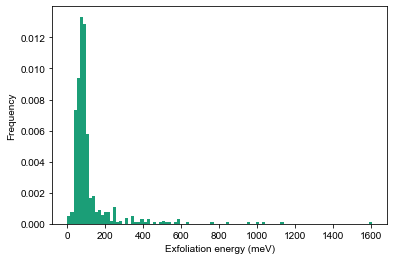

In [9]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["exfoliation_en"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Exfoliation energy (meV)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [ ]:
PRECOMPUTED_MODDATA = "./precomputed/matbench_jdft2d.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_jdft2d")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["exfoliation_en"].tolist(), 
        target_names=["Exfoliation energy (meV)"],
        featurizer=DeBreuck2020Featurizer(n_jobs=4)
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)

In [6]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel(data.target_names[0])

AttributeError: 'MODData' object has no attribute 'optimal_features'

In [7]:
data.save(PRECOMPUTED_MODDATA)

INFO:root:Data successfully saved as ./precomputed/matbench_jdft2d.pkl.gz!
